# Exploratory Data Analysis on CIFAR-10 Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (_, _) = cifar10.load_data()

# Select only "Cats" (label=3) and "Dogs" (label=5)
mask = (y_train.flatten() == 3) | (y_train.flatten() == 5)
X_train, y_train = X_train[mask], y_train[mask]

# Convert labels: 3 -> 0 (Cat), 5 -> 1 (Dog)
y_train = (y_train == 5).astype(int)


In [4]:
# Sample 3000 images from each class
cat_indices = np.where(y_train == 0)[0]
dog_indices = np.where(y_train == 1)[0]

np.random.shuffle(cat_indices)
np.random.shuffle(dog_indices)

cat_indices = cat_indices[:3000]
dog_indices = dog_indices[:3000]

selected_indices = np.concatenate([cat_indices, dog_indices])
np.random.shuffle(selected_indices)

X_train, y_train = X_train[selected_indices], y_train[selected_indices]

In [5]:
num_images = X_train.shape[0]
print(num_images)

6000


In [6]:
height, width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
image_size = height * width * channels
X_train_reshaped = X_train.reshape(num_images, image_size)

channel_names = ['r', 'g', 'b']
column_names = [f"pixel_{x}_{y}_{channel_names[c]}" for x in range(height) for y in range(width) for c in range(channels)]

df = pd.DataFrame(X_train_reshaped, columns=column_names)
df['label'] = y_train

print(df.head())

   pixel_0_0_r  pixel_0_0_g  pixel_0_0_b  pixel_0_1_r  pixel_0_1_g  \
0          181          148          152          130           97   
1          201          201          201          208          208   
2          202          127           24          204          134   
3           84           99           52           67           91   
4           26           10            6           29           10   

   pixel_0_1_b  pixel_0_2_r  pixel_0_2_g  pixel_0_2_b  pixel_0_3_r  ...  \
0          101          159          127          131          236  ...   
1          208          211          211          211          211  ...   
2           33          229          161           67          148  ...   
3           32           74           97           44           83  ...   
4            6           26           11            4           29  ...   

   pixel_31_29_r  pixel_31_29_g  pixel_31_29_b  pixel_31_30_r  pixel_31_30_g  \
0            186            162            163  

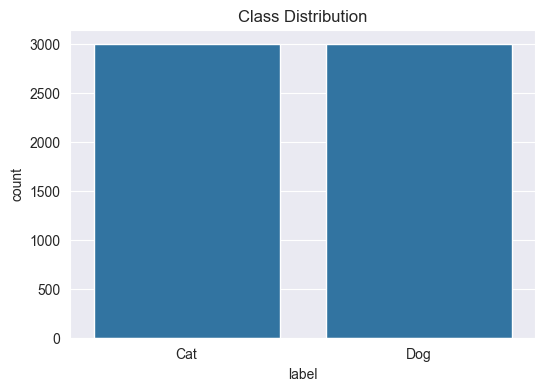

In [7]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.show()

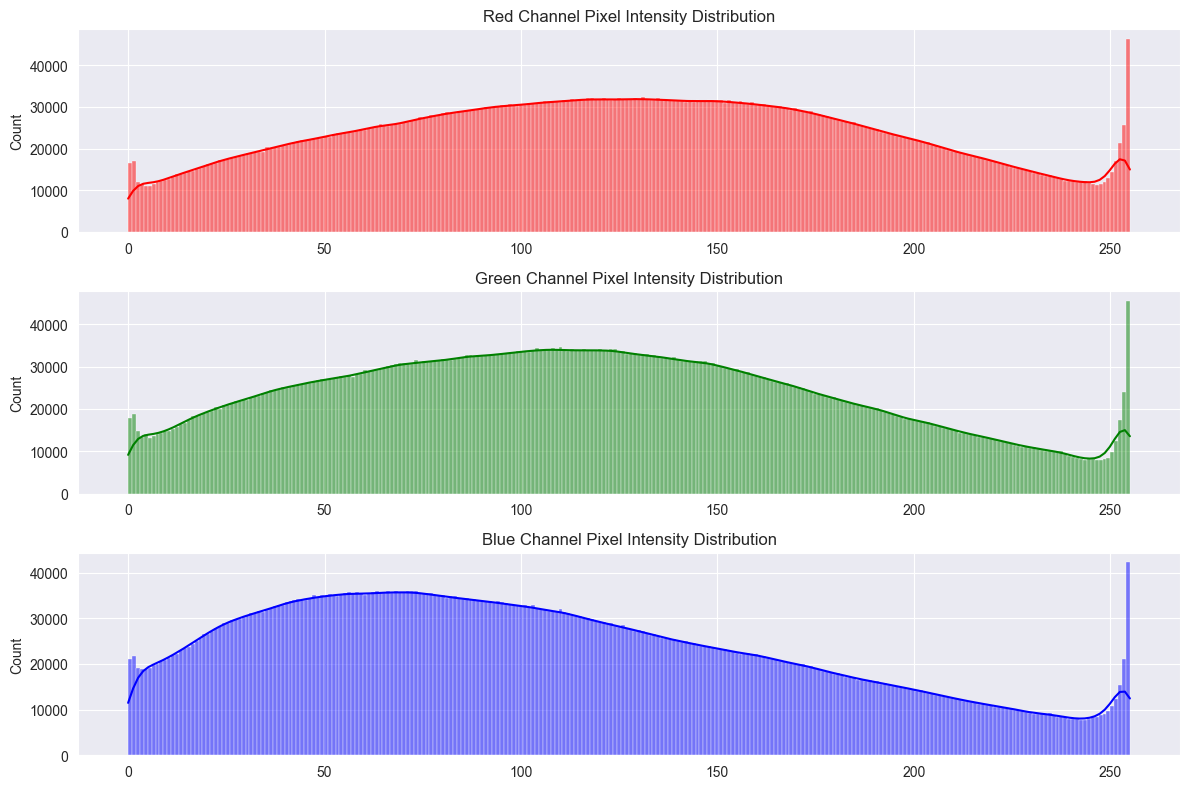

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
sns.histplot(df.filter(like='_r').values.flatten(), bins=256, color='red', kde=True)
plt.title('Red Channel Pixel Intensity Distribution')

plt.subplot(3, 1, 2)
sns.histplot(df.filter(like='_g').values.flatten(), bins=256, color='green', kde=True)
plt.title('Green Channel Pixel Intensity Distribution')

plt.subplot(3, 1, 3)
sns.histplot(df.filter(like='_b').values.flatten(), bins=256, color='blue', kde=True)
plt.title('Blue Channel Pixel Intensity Distribution')

plt.tight_layout()
plt.show()

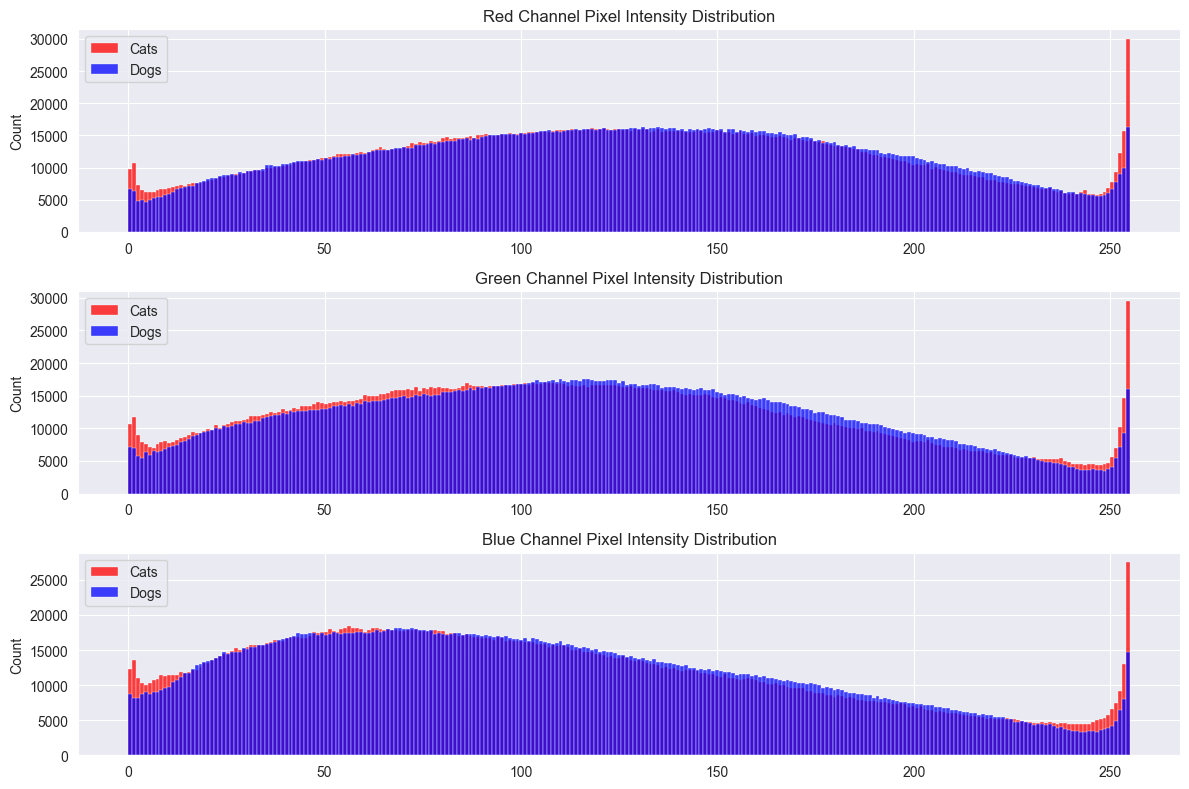

In [13]:
df_cats = df[df['label'] == 0]
df_dogs = df[df['label'] == 1]

plt.figure(figsize=(12, 8))

# Red Channel
plt.subplot(3, 1, 1)
sns.histplot(df_cats.filter(like='_r').values.flatten(), bins=256, color='red', label='Cats')
sns.histplot(df_dogs.filter(like='_r').values.flatten(), bins=256, color='blue', label='Dogs')
plt.title('Red Channel Pixel Intensity Distribution')
plt.legend()

# Green Channel
plt.subplot(3, 1, 2)
sns.histplot(df_cats.filter(like='_g').values.flatten(), bins=256, color='red', label='Cats')
sns.histplot(df_dogs.filter(like='_g').values.flatten(), bins=256, color='blue', label='Dogs')
plt.title('Green Channel Pixel Intensity Distribution')
plt.legend()

# Blue Channel
plt.subplot(3, 1, 3)
sns.histplot(df_cats.filter(like='_b').values.flatten(), bins=256, color='red', label='Cats')
sns.histplot(df_dogs.filter(like='_b').values.flatten(), bins=256, color='blue', label='Dogs')
plt.title('Blue Channel Pixel Intensity Distribution')
plt.legend()

plt.tight_layout()
plt.show()

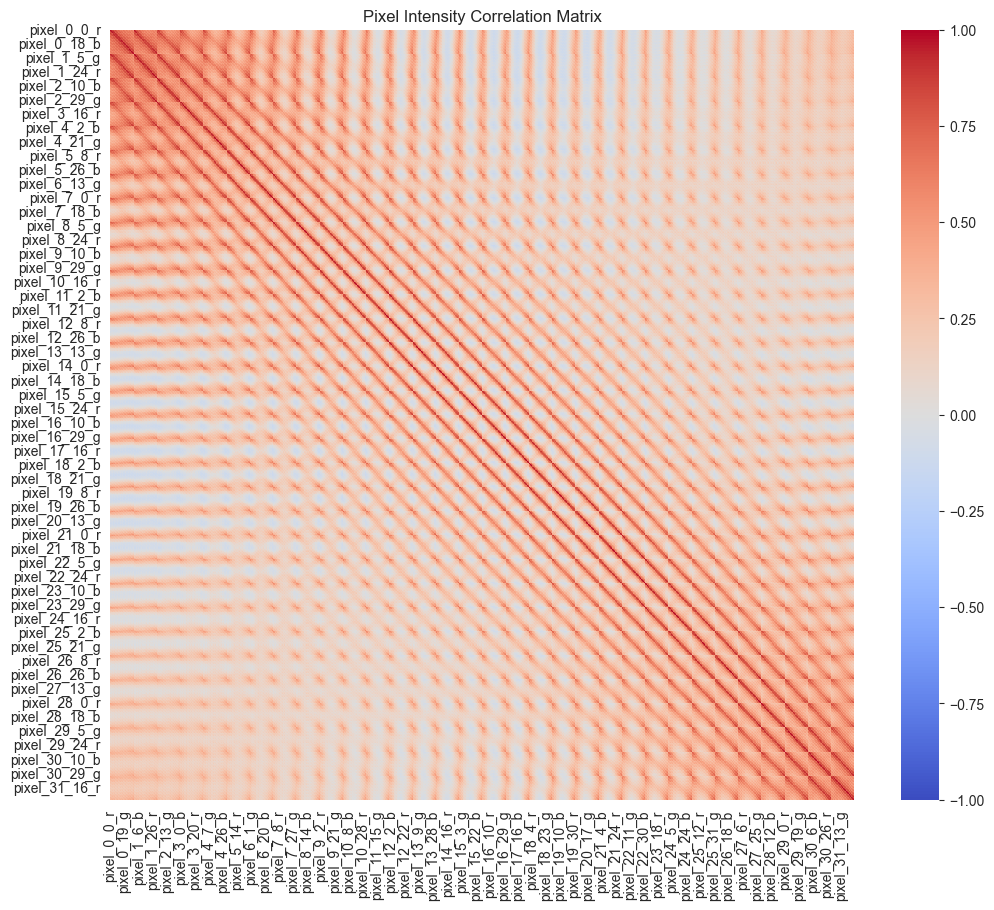

In [14]:
# Correlation Matrix
corr_matrix = df.drop(columns=['label']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pixel Intensity Correlation Matrix')
plt.show()

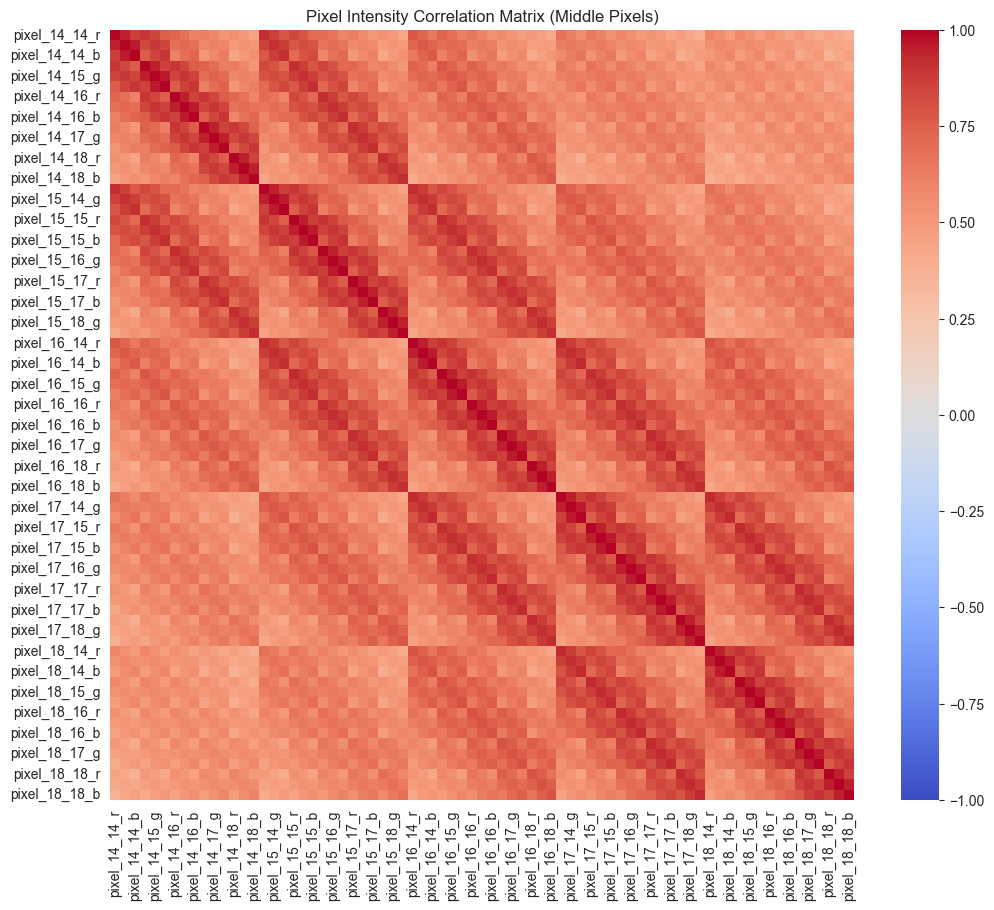

In [20]:
# (14,14 - 18,18 range)
middle_pixel_columns = [f"pixel_{x}_{y}_{channel}" for x in range(14, 19) for y in range(14, 19) for channel in ['r', 'g', 'b']]

# Filter the DataFrame to include only the middle pixel columns
df_middle_pixels = df[middle_pixel_columns]

# Calculate the correlation matrix for the middle pixels
corr_matrix_middle = df_middle_pixels.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_middle, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pixel Intensity Correlation Matrix (Middle Pixels)')
plt.show()

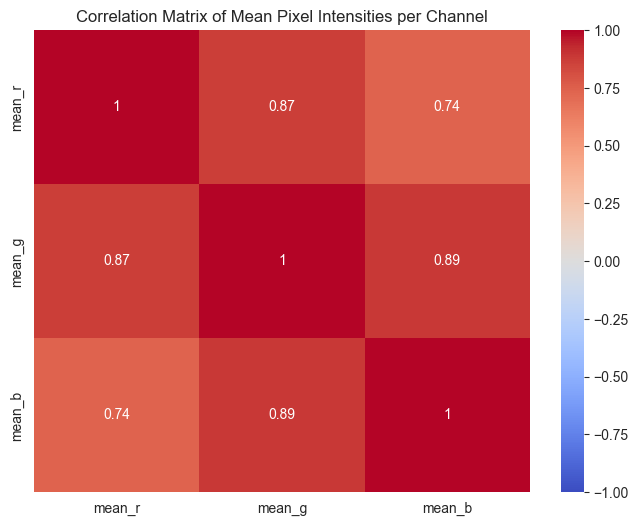

In [16]:
# Calculate mean pixel intensity for each channel per image
df['mean_r'] = df.filter(like='_r').mean(axis=1)
df['mean_g'] = df.filter(like='_g').mean(axis=1)
df['mean_b'] = df.filter(like='_b').mean(axis=1)

# Create a new DataFrame with the mean values
mean_df = df[['mean_r', 'mean_g', 'mean_b']]

# Calculate the correlation matrix
corr_matrix_means = mean_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_means, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Mean Pixel Intensities per Channel')
plt.show()

# Test logistic regression accuracy

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled[:5])

[[0.75294118 0.73333333 0.86666667 ... 0.54866547 0.50892052 0.52861724]
 [0.99607843 0.99215686 0.99607843 ... 0.80856094 0.86651461 0.86803827]
 [0.94117647 0.84313725 0.6745098  ... 0.4145706  0.56498934 0.51377739]
 [0.15686275 0.07058824 0.02745098 ... 0.61056579 0.54915579 0.45627026]
 [0.37647059 0.40392157 0.45882353 ... 0.47364482 0.50510629 0.52517668]]


In [57]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Cat', 'Dog'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.58
Classification Report:
              precision    recall  f1-score   support

         Cat       0.59      0.58      0.59       611
         Dog       0.57      0.59      0.58       589

    accuracy                           0.58      1200
   macro avg       0.58      0.58      0.58      1200
weighted avg       0.58      0.58      0.58      1200



In [35]:
# Test logistic regression accuracy with regularization
# model = LogisticRegression(max_iter=1000, C=0.1)
# model.fit(X_train_scaled, y_train)
#
# y_pred = model.predict(X_test_scaled)
#
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred, target_names=['Cat', 'Dog'])
#
# print(f"Accuracy: {accuracy:.2f}")
# print("Classification Report:")
# print(report)

Accuracy: 0.61
Classification Report:
              precision    recall  f1-score   support

         Cat       0.62      0.61      0.61       611
         Dog       0.60      0.61      0.61       589

    accuracy                           0.61      1200
   macro avg       0.61      0.61      0.61      1200
weighted avg       0.61      0.61      0.61      1200



In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

feature_names = X.columns
coefficients = model.coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the most impactful features
print(coef_df.head(10))

            Feature  Coefficient  Absolute Coefficient
2111  pixel_21_31_b    -1.165437              1.165437
1749   pixel_18_7_r    -1.065390              1.065390
1871  pixel_19_15_b     1.058771              1.058771
2868  pixel_29_28_r     1.057406              1.057406
1991  pixel_20_23_b     1.014122              1.014122
605     pixel_6_9_b    -0.999584              0.999584
1348   pixel_14_1_g     0.968299              0.968299
28      pixel_0_9_g     0.937143              0.937143
10      pixel_0_3_g     0.936790              0.936790
2309   pixel_24_1_b     0.913164              0.913164


In [59]:
coef_df_wo_mean = pd.DataFrame({'Feature': feature_names[:-3], 'Coefficient': coefficients[:-3]})

coef_df_wo_mean['X'] = coef_df_wo_mean['Feature'].apply(lambda x: int(x.split('_')[1]))
coef_df_wo_mean['Y'] = coef_df_wo_mean['Feature'].apply(lambda x: int(x.split('_')[2]))
coef_df_wo_mean['Channel'] = coef_df_wo_mean['Feature'].apply(lambda x: x.split('_')[3])

# Sort the DataFrame by pixel position and color channel
coef_df_wo_mean = coef_df_wo_mean.sort_values(by=['X', 'Y', 'Channel'])

coefficients_sorted = coef_df_wo_mean['Coefficient'].values
coefficients_r = coefficients_sorted[:height * width].reshape((height, width))
coefficients_g = coefficients_sorted[height * width:2 * height * width].reshape((height, width))
coefficients_b = coefficients_sorted[2 * height * width:].reshape((height, width))


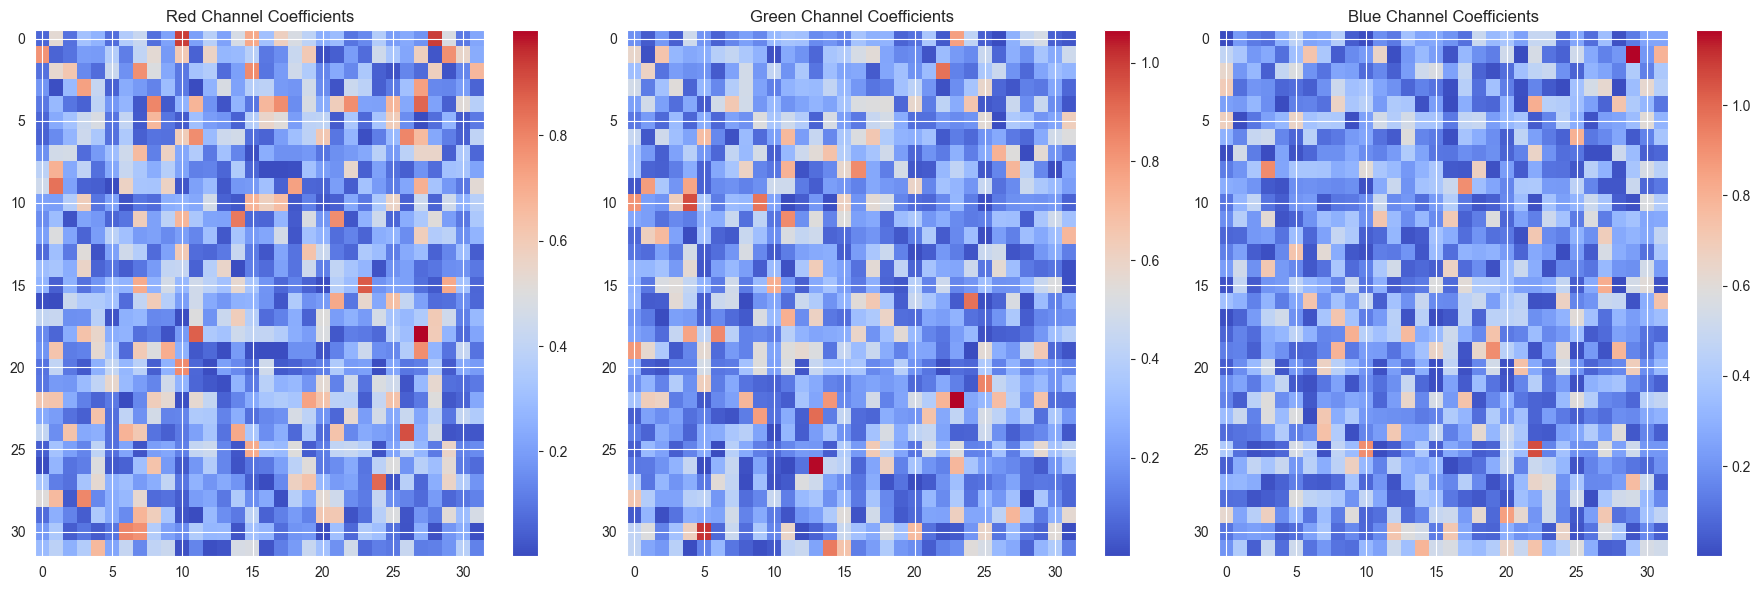

In [60]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(abs(coefficients_r), cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Red Channel Coefficients')

plt.subplot(1, 3, 2)
plt.imshow(abs(coefficients_g), cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Green Channel Coefficients')

plt.subplot(1, 3, 3)
plt.imshow(abs(coefficients_b), cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Blue Channel Coefficients')

plt.tight_layout()
plt.show()